In [1]:
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clip
from matplotlib import colors
from astropy.convolution import convolve, Gaussian2DKernel
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt

### F$_{\nu}$ $c/{\lambda^{2}}$=F$_{\lambda}$

In [2]:
def count2flux(img_count,replacer=1e-10,
               lamda=21650,delta_lamda=250):
    '''
    convert counts map to flux map.
    lamda and delta_lamda in unit of 250 
    '''
    #replace negtive value with positive
    img_count[img_count<=0]=replacer
    
    mag=-2.5*np.log10(img_count)+24.37
    flux_nu=10**(-(mag+48.6)/2.5)
    flux_lamda=flux_nu*const.c.to(u.AA/u.second).value/(lamda**2)
    flux=flux_lamda*delta_lamda*u.erg/(u.second*(u.cm**2))
    
    return flux

def pix2world(shape,delta,origin_pix,origin_world):
    '''
    convert pixel coordinate to
    ra,dec, origin_pix and origin_world
    is the coordinate of origin in 
    different frame. They are both 1-d
    array with two elements
    return two 1-d arrays of ra and 
    dec respectively
    '''
    
    x,y=np.arange(shape[1]),np.arange(shape[0])
    X,Y=np.meshgrid(x,y)
    ra_map=(origin_pix[0]-X)*delta[0]+origin_world[0]
    dec_map=(origin_pix[1]-Y)*delta[1]+origin_world[1]
    
    return ra_map.mean(axis=0), dec_map.mean(axis=1)

In [3]:
dic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/results/'
h_alpha_fits=fits.open(dic+'MORICS_MAMMOTH1_sub.fits')

convert counts to flux

In [4]:
img_count=h_alpha_fits[0].data
img_flux=count2flux(img_count)

smooth the data use a gaussian kernel with size of 12 and standard deviation of 3 corresponding to radius of 1.4"

In [5]:
kernel=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=13,y_size=13)
smoothed_img_flux=convolve(img_flux.value,kernel)

H$\rm \alpha$ total flux;source spatial position:105: 280, 50: 244

In [6]:
smoothed_img_flux[105: 280, 50: 244].sum()

4.8549394479968945e-15

calculate the noise of background and produce the snr map select a region without signal 200:,250:. Set pixels < 4$\rm \sigma$--> 0

In [7]:
noise=smoothed_img_flux[200:,250:].std()
img_snr=smoothed_img_flux/noise
smoothed_img_flux[img_snr<4]=smoothed_img_flux.min()*1e-10

cut image

In [8]:
replacer=smoothed_img_flux.min()*1e-10
smoothed_img_flux[255:]=replacer
smoothed_img_flux[:130]=replacer
smoothed_img_flux[:,200:]=replacer
smoothed_img_flux[:,:58]=replacer
smoothed_img_flux[130:175,50:100]=replacer
smoothed_img_flux[235:260,50:80]=replacer
smoothed_img_flux[130:155,180:200]=replacer
smoothed_img_flux[235:260,160:200]=replacer

calculate the SNR map

In [9]:
img_snr=smoothed_img_flux/noise

convert physical coordinate to ra,dec

In [10]:
delta=[(6.864583279e-05)/2.,(7.077716112e-05)/2.05]
origin_pix=[148,199]
origin_world=[220.3520886, 40.05269183]
ra,dec=pix2world(img_flux.shape,delta,origin_pix,origin_world)
delta_ra=(ra-origin_world[0])*u.deg.to(u.arcsecond)
delta_dec=(dec-origin_world[1])*u.deg.to(u.arcsecond)

add the sources coordinate

In [11]:
sources_list=np.array([[220.3517351,40.05269063],
                       [220.3521004,40.05267509],
                       [220.3519736,40.05221132],
                       [220.3520722,40.05297709],
                       
                       [220.3531717,40.05223288],
                       [220.3497255,40.05104434],
                       [220.3492992,40.05225575],
                       [220.3499296,40.05351636],
                       [220.3525,40.0545]])*u.deg
sources_list[:,0]=sources_list[:,0]-0.0002*u.deg
source_name=['source-B','G-3','G-4','G-6','G-5','G-1']
source_name_coor=np.array([[220.3520722,40.05297709],[220.3531717,40.05223288],
                           [220.3497255,40.05104434],[220.3492992,40.05225575],
                           [220.3499296,40.05351636],[220.3525,40.0545]])*u.deg
delta_sources=(sources_list-origin_world*u.deg).to(u.arcsec).value
delta_source_name_coor=(source_name_coor-origin_world*u.deg).to(u.arcsec).value

Plot the flux image

In [ ]:
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/'
np.savetxt(savdic+'H-alpha_intensity.txt',smoothed_img_flux)
np.savetxt(savdic+'H-alpha_ra.txt',delta_ra)
np.savetxt(savdic+'H-alpha_dec.txt',delta_dec)

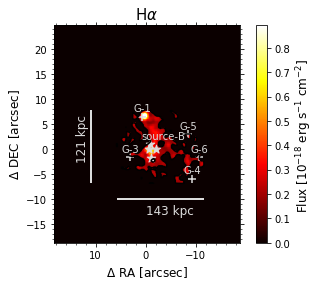

In [12]:
fig_dic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/draft_code/paper/ApJtemplate/figs/'
dec_map,ra_map=np.meshgrid(delta_dec,delta_ra)
smoothed_img_flux_c=smoothed_img_flux*1e18
fig,ax=plt.subplots(1,1)
#plot image and contour
img=ax.pcolormesh(ra_map[::-1,:].T,dec_map.T,smoothed_img_flux_c,
                  cmap='hot',vmax=smoothed_img_flux_c.max()*0.7,vmin=0)
contour=ax.contour(ra_map[::-1,:].T,dec_map.T,img_snr,levels=[4],colors='black')
ax.invert_xaxis()
ax.set_xlabel(r'$\rm \Delta \ RA \ [arcsec]$',fontsize=12)
ax.set_ylabel(r'$\rm \Delta \ DEC \ [arcsec]$',fontsize=12)
ax.set_title(r'H$\alpha$',fontsize=15)
#add colorbar
cbar=plt.colorbar(img)
cbar.ax.set_ylabel(r'Flux [10$^{-18}$ erg s$^{-1}$ cm$^{-2}$] ',fontsize=12)
#add sources
for i in range(4):
    ax.scatter(delta_sources[i,0],delta_sources[i,1],marker='*',color='gainsboro',s=80)
for i in range(4,delta_sources.shape[0]):
    ax.scatter(delta_sources[i,0],delta_sources[i,1],marker='+',color='gainsboro',s=80)
for i in range(len(source_name)):
    ax.annotate(source_name[i],xy=(delta_source_name_coor[i,0],delta_source_name_coor[i,1]),
                xytext=(-5,5),textcoords="offset points",color='gainsboro')

#add arrow
arrow_line_dec=[dec_map.T[np.log10(smoothed_img_flux)>-20].min(),
                dec_map.T[np.log10(smoothed_img_flux)>-20].max()]
arrow_line_ra=[ra_map[::-1,:].T[np.log10(smoothed_img_flux)>-20].min(),
               ra_map[::-1,:].T[np.log10(smoothed_img_flux)>-20].max()]
ax.vlines(x=11,ymin=arrow_line_dec[0],ymax=arrow_line_dec[1],lw=2,color='gainsboro')
ax.hlines(y=-10,xmin=arrow_line_ra[0],xmax=arrow_line_ra[1],lw=2,color='gainsboro')
ax.text(14,5,'121 kpc',color='gainsboro',fontsize=12,rotation=90)
ax.text(0,-13,'143 kpc',color='gainsboro',fontsize=12)
ax.minorticks_on()
ax.set_aspect('equal', adjustable='box')
ax.tick_params(axis='both', which='both',top=True,right=True)
fig_dic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/draft_code/paper/ApJtemplate/figs/'
# plt.savefig(fig_dic+'H_alpha.png',dpi=300)
plt.show()

In [ ]:
# save snr map as .fits for contour plot
result_dic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/'
hdu=fits.PrimaryHDU(data=smoothed_img_flux,header=h_alpha_fits[0].header)
hdul=fits.HDUList([hdu])
hdul.writeto(result_dic+'H_alpha_flux.fits')